In [1]:
import numpy as np
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf

In [2]:
# define a single block to figure things out with:
# this step creates block_collection - a list of BlockSync objects of interest
block_numbers = range(23,24)
bad_blocks = [42, 61, 62, 64, 65, 66]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_62'
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b

block = block_collection[0]

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!


In [3]:
block.handle_eye_videos()

handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_04_27\\block_023\\eye_videos\\LE\\230427_pv62_trial1_640x480_60hz_experiment_1_recording_0\\230427_pv62_trial1.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_04_27\\block_023\\eye_videos\\RE\\230427_pv62_trial1_640x480_60hz_experiment_1_recording_0\\230427_pv62_trial1.h264'] 
 avoiding conversion on files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_04_27\\block_023\\eye_videos\\LE\\230427_pv62_trial1_640x480_60hz_experiment_1_recording_0\\230427_pv62_trial1_LE.mp4', 'Z:\\Nimrod\\experiments\\PV_62\\2023_04_27\\block_023\\eye_videos\\RE\\230427_pv62_trial1_640x480_60hz_experiment_1_recording_0\\230427_pv62_trial1.mp4']
The file Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\eye_videos\RE\230427_pv62_trial1_640x480_60hz_experiment_1_recording_0\230427_pv62_trial1.mp4 already exists, no conversion necessary
Validating videos...
The video named 230427_pv62_trial1_LE.mp4 has reported 97331 fra

In [4]:
block.handle_arena_files()

handling arena files
no arena timestamps folder found
Arena video Names:
back_20230427T105308.mp4
top_20230427T105308.mp4


In [5]:
block.parse_open_ephys_events()
block.get_eye_brightness_vectors()
block.synchronize_block()
block.create_eye_brightness_df(threshold_value=20)


running parse_open_ephys_events...
block 023 has a parsed events file, reading...
getting eye brigtness values for block 023...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder


,Arena_TTL,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
0,787580.0,773.0,0.0,1.0,-0.733501,2.008356
1,787920.0,774.0,1.0,2.0,-0.712526,2.009028
2,788260.0,775.0,3.0,3.0,-0.694872,2.001443
3,788600.0,776.0,4.0,4.0,-0.804954,1.991896
4,788939.0,777.0,5.0,5.0,-0.843378,1.989095
...,...,...,...,...,...,...
94805,33022706.0,95578.0,96795.0,96797.0,-0.714197,1.919440
94806,33023045.0,95579.0,96796.0,96798.0,-0.717544,1.920064
94807,33023385.0,95580.0,96798.0,96799.0,-0.708953,1.920682
94808,33023725.0,95581.0,96798.0,96800.0,-0.708953,1.919944


In [6]:
block.import_manual_sync_df()
block.read_dlc_data()

eye dataframes loaded from analysis folder


In [7]:
block.saccade_dict_creation_3d(2000,15,True,False)

path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\oe_files\2023-04-27_10-52-42\Record Node 108\analysis\recNames=Block0023,Animal=PV_62\lizMov.mat
loaded chunked saccade data from analysis folder
getting data with block_number 023: 
There are 556 saccade events: 
pre_saccade_ts = [  38430.     39126.35   39364.1    40587.     46717.75   48246.2
   50046.4    50199.3    50555.9    51116.35   51218.3    51371.1
   51710.7    53545.     53697.85   53833.75   54428.15   54581.
   55073.55   56041.65   59591.1    62800.5    65500.9    72633.85
   81686.8    86561.65   86833.4    88039.25   88158.15   88260.05
   88446.9    88514.8    88599.7    88752.6    88939.4    89007.35
   89414.9    91130.15   91571.7    92081.15   92488.75   92590.65
   93338.05   94000.35   95222.95   96394.7    98483.5    98840.2
   99111.9    99791.25  101183.75  103153.8   110796.55  115909.
  116724.35  119646.15  119833.    120240.65  121531.2   121633.15
  121768.95  121836.9   122006.7   12

In [8]:
block.synced_saccades_df

,datetime,block,eye,timestamps,fs,pxx,samples,x_coords,y_coords,vid_inds,x_speed,y_speed,magnitude,dx,dy,direction,accel,calib_dx,calib_dy
0,2023-04-27_10-52-42,023,L,38430,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[20.123777183965192, 116.47016856835471, 136.6...","[19.695, 17.55, 15.99, 24.96, 10.5300000000000...","[-2.722385320513065, -2.7220221226769814, -2.7...","[2.088379138952184, 2.088766117332091, 2.08835...","[0, 340, 680, 1020, 1359, 1699, 2039, 2378, 27...","[0.0, 0.00036319783608362854, -0.0025278362611...","[0.0, 0.00038697837990664397, -0.0004070591155...",0.062496,-0.0217268,-0.0585977,249.656,0,-0.00120747,-0.00325658
1,2023-04-27_10-52-42,023,L,39126.3,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[175.20483361960146, 511.78483561918284, 317.6...","[-69.03, -35.88, -41.925000000000004, -40.17, ...","[-2.722385320513065, -2.7220221226769814, -2.7...","[2.088379138952184, 2.088766117332091, 2.08835...","[0, 340, 680, 1020, 1359, 1699, 2039, 2378, 27...","[0.0, 0.00036319783608362854, -0.0025278362611...","[0.0, 0.00038697837990664397, -0.0004070591155...",0.062496,-0.0217268,-0.0585977,249.656,0,-0.00120747,-0.00325658
2,2023-04-27_10-52-42,023,L,39364.1,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[53.16167230379791, 552.5918532815222, 425.670...","[6.045, -0.195, 19.695, 10.725, 1.950000000000...","[-2.722385320513065, -2.7220221226769814, -2.7...","[2.088379138952184, 2.088766117332091, 2.08835...","[0, 340, 680, 1020, 1359, 1699, 2039, 2378, 27...","[0.0, 0.00036319783608362854, -0.0025278362611...","[0.0, 0.00038697837990664397, -0.0004070591155...",0.062496,-0.0217268,-0.0585977,249.656,0,-0.00120747,-0.00325658
3,2023-04-27_10-52-42,023,L,40587,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[12.406281174509028, 84.77867965921041, 69.621...","[19.305, 9.945, 19.305, 12.48, 21.45, 37.83, 2...","[-2.7374948097032714, -2.737752235247159, -2.7...","[2.059583754348824, 2.059335306010424, 2.05937...","[0, 339, 679, 1019, 1358, 1698, 2038, 2377, 27...","[0.0, -0.00025742554388763494, -0.000182974860...","[0.0, -0.0002484483383997649, 4.44715793452843...",0.0527638,-0.0474871,0.0229997,115.843,0,-0.00263911,0.00127822
4,2023-04-27_10-52-42,023,L,46717.8,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[1.8362881819092733, 260.09447409875474, 535.0...","[-60.645, -68.055, -72.54, -99.25500000000001,...","[-2.75391353911953, -2.753773404838437, -2.753...","[2.1002903792305267, 2.1005818956631868, 2.100...","[0, 340, 680, 1020, 1359, 1699, 2038, 2379, 27...","[0.0, 0.00014013428109338477, 5.30511966982949...","[0.0, 0.0002915164326600106, 1.518807184464066...",0.0288388,0.0118709,0.0262823,65.6927,0,0.000659731,0.00146065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,2023-04-27_10-52-42,023,R,1.63269e+06,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[18.57948226039998, 49.66577394994716, 80.8625...","[-46.410000000000004, -48.945, -55.77, -60.645...","[-2.243752342733139, -2.2475511546846123, -2.2...","[1.430332407818225, 1.4304615683117279, 1.4304...","[0, 339, 680, 1019, 1359, 1698, 2038, 2378, 27...","[0.0, -0.0037988119514733576, -0.0002362968092...","[0.0, 0.00012916049350297776, -4.5719491728046...",0.186959,-0.186333,0.0152888,94.6907,0,-0.00961323,0.000788777
1002,2023-04-27_10-52-42,023,R,1.63599e+06,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[22.748985339186785, 53.8915393077018, 42.4521...","[48.36, 55.185, 53.235, 40.95, 62.79, 62.595, ...","[-2.323164915721837, -2.3231804716878224, -2.3...","[1.4309495857760577, 1.4309556220417778, 1.430...","[0, 340, 679, 1019, 1359, 1699, 2039, 2378, 27...","[0.0, -1.5555965985569742e-05, 0.0007284733370...","[0.0, 6.036265720155143e-06, -5.83968442147142...",0.196479,0.196346,0.00722921,2.10861,0,0.0101298,0.000372967
1003,2023-04-27_10-52-42,023,R,1.6427e+06,"[0.0, 1.220703125, 2.44140625, 3.662109375, 4....","[25.314689423600814, 84.05400064889808, 102.74...","[-11.895, -19.

In [68]:
# get the left eye saccades, but with the 3D approximations:
l_eye_saccade_start_times = block.synced_saccades_df.query('eye=="L"').timestamps.values + 1000

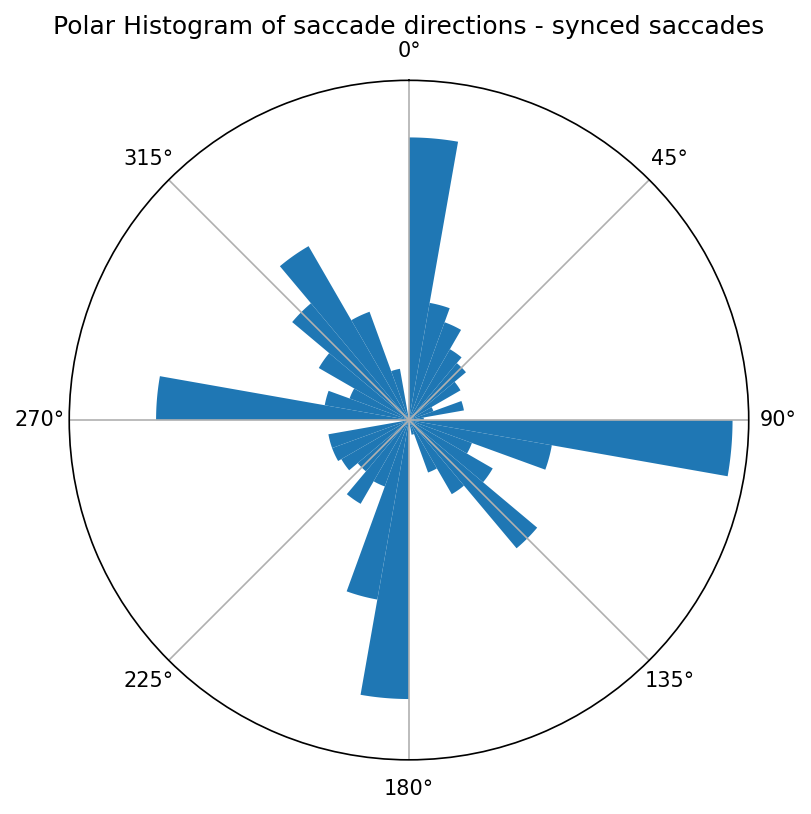

In [10]:
vals = block.synced_saccades_df.direction # synced saccades
num_bins = 36
hist, bin_edges = np.histogram(vals, bins=num_bins, range=(0, 360))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

plt.figure(figsize=(8, 6), dpi=150)
ax = plt.subplot(111, projection='polar')

ax.bar(np.deg2rad(list(bin_centers.astype(int))), hist, width=np.deg2rad(360/num_bins), align='center')

ax.set_theta_direction(-1)
ax.set_theta_offset(np.radians(90))
ax.grid(True)
#ax.set_rlabel_position(0)
ax.set_yticks([])
plt.title("Polar Histogram of saccade directions - synced saccades")

plt.show()

In [8]:
le_df_3d = pd.read_csv(block.analysis_path / 'le_df_3d.csv',index_col=0)
le_df_3d = le_df_3d[['timestamp','diameter','theta','phi']]
le_df_3d.head()


,timestamp,diameter,theta,phi
0,39379.00,30.947106,2.088379,-2.722385
1,39396.00,30.801153,2.088766,-2.722022
2,39413.00,31.270568,2.088359,-2.724550
3,39430.00,31.925210,2.066025,-2.730719
4,39446.95,31.456465,2.047101,-2.731785


In [10]:
block.re_df

,Unnamed: 0.1,Arena_TTL,R_eye_frame,L_values,R_values,center_x,center_y,width,height,phi,ellipse_size,ms_axis
0,0,787580.0,NaN,-0.733501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39379.00
1,1,787920.0,1.0,-0.712526,2.008356,255.850789,283.441440,17.486314,37.180060,0.727977,2042.481990,39396.00
2,2,788260.0,2.0,-0.694872,2.009028,256.271489,283.261060,17.716669,37.038480,0.734475,2061.508308,39413.00
3,3,788600.0,3.0,-0.804954,2.001443,254.707576,283.306501,16.799509,36.826160,0.729896,1943.582118,39430.00
4,4,788939.0,4.0,-0.843378,1.991896,251.413679,287.786332,15.717783,36.066218,0.720839,1780.909139,39446.95
...,...,...,...,...,...,...,...,...,...,...,...,...
94805,94805,33022706.0,96796.0,-0.714197,1.918472,260.079673,258.332453,44.188709,29.699803,-0.641598,4123.013460,1651135.30
94806,94806,33023045.0,96797.0,-0.717544,1.919440,260.066693,258.357440,44.270369,29.693419,-0.638244,4129.744842,1651152.25
94807,94807,33023385.0,96798.0,-0.708953,1.920064,260.048872,258.381072,44.203031,29.794705,-0.638730,4137.528587,1651169.25
94808,94808,33023725.0,96799.0,-0.708953,1.920682,260.104222,258.227558,44.235994,29.640548,-0.638985,4119.190543,1651186.25


In [40]:
angular_displacement_phi = le_df_3d['phi'].diff()
angular_displacement_theta = le_df_3d['theta'].diff()
#angular_velocity = np.sqrt()
angular_displacement_phi

0             NaN
1        0.000363
2       -0.002528
3       -0.006169
4       -0.001066
           ...   
94805    0.000173
94806   -0.000317
94807    0.000034
94808    0.000000
94809    0.000174
Name: phi, Length: 94810, dtype: float64

In [58]:
# start from interpolating over the dataframe:
le_df_3d.interpolate(method='linear',inplace=True)

# now get the angular_velocity measurement
angular_displacement_phi = le_df_3d['phi'].diff()
angular_displacement_theta = le_df_3d['theta'].diff()
angular_displacement = np.sqrt(angular_displacement_phi**2 + angular_displacement_theta**2)
le_df_3d['angular_displacement'] = angular_displacement
le_df_3d['delta_t'] = le_df_3d['timestamp'].diff()
le_df_3d['angular_velocity'] = le_df_3d['angular_displacement'] / le_df_3d['delta_t']
window_size= 11
le_df_3d['rolling_avg_angular_velocity'] = le_df_3d['angular_velocity'].rolling(window=window_size, center=True).mean()

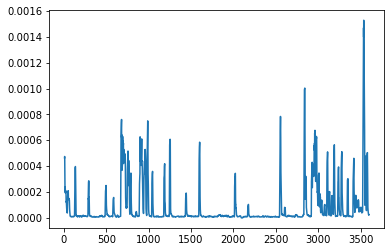

In [65]:
# sanity plots:
velocity_measurement = le_df_3d.angular_velocity.values
x_axis = le_df_3d.timestamp
saccade_locations = l_eye_saccade_start_times


In [79]:
block.saccade_dict['L'].keys()

dict_keys(['timestamps', 'fs', 'pxx', 'samples', 'x_coords', 'y_coords', 'vid_inds', 'accel'])

In [75]:
from bokeh.plotting import figure, show
from bokeh.models import Span
import pandas as pd

# Sample data (replace with your actual data)
velocity_measurement = le_df_3d.angular_velocity.values
x_axis = le_df_3d.timestamp  # Keep x_axis as raw values
saccade_locations = l_eye_saccade_start_times

# Set the desired aspect ratio (7:15)
aspect_ratio = 7 / 15

# Calculate the plot width and height based on the aspect ratio
plot_width = 1800  # Adjust as needed
plot_height = int(plot_width * aspect_ratio)

# Create a Bokeh figure with the specified width and height
p = figure(
    title="Angular Velocity Measurement",
    x_axis_label="Raw X Axis",
    y_axis_label="Velocity",
    plot_width=plot_width,
    plot_height=plot_height,
)

# Line plot of velocity_measurement
p.line(x_axis, velocity_measurement, legend_label="Velocity", line_color="blue")

# Add vertical lines at saccade locations
for saccade_time in saccade_locations:
    saccade_line = Span(location=saccade_time, dimension="height", line_color="red", line_width=2, line_alpha=0.3)
    p.add_layout(saccade_line)

# Customize the plot further (e.g., add tooltips, adjust axis labels, etc.) as needed

# Show the Bokeh plot
show(p)
